In [100]:
import math
import io
import torch
from torchvision import transforms
import numpy as np
import pickle
import re
import scipy.stats as st
import PIL
from collections import Counter
from PIL import Image
from PIL import ImageChops
import imageio
from pytorch_msssim import ssim, ms_ssim
import matplotlib.pyplot as plt
from statistics import mean
import compressai
import skimage
import torch.nn.functional as F


In [66]:
from compressai.zoo import bmshj2018_factorized
from compressai.dna_entropy_coding.coder import Coder
from ipywidgets import interact, widgets

In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [68]:
JPEG_SIZES = [
    '1192x832', 
    '853x945', 
    '945x840', 
    '2000x2496', 
    '560x888',
    '2048x1536', 
    '1600x1200', 
    '1430x1834', 
    '2048x1536', 
    '2592x1946'  
]

### Image extraction

In [69]:
def get_original_tensor(img_number, data_set): 
    if data_set == 'kodak':
        img_name = '/kodim{:02d}.png'.format(img_number)
        
    if data_set == 'jpeg_dna': 
        img_name = f"/{str(img_number).zfill(5)}_" + JPEG_SIZES[img_number-1]+'.png'
        
    img = Image.open('./assets/' + data_set + img_name).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [70]:
def get_learningbased_tensor(img_number, quality, data_set):
    path = 'assets/' + data_set +'/learningbased'
    
    if data_set == 'kodak': 
        img_name = '/{}kodim{:02d}.png'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        img_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '_decoded' + '.jpg'
    
    img = Image.open(path+ img_name).convert('RGB')   
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x


In [71]:
def get_learningbased_dna(img_number, quality, data_set):
    path = 'assets/' + data_set +'/learningbased'
    
    if data_set == 'kodak': 
        dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        dna_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '.fasta'
    
    fasta_file = open(path + dna_name)
    dna = fasta_file.read()
    fasta_file.close()
    return dna


In [72]:
def get_anchor_tensor(anchor, img_number, quality, data_set): 
    '''
    Inputs : 
        anchor = int (1 or 3) 
        quality = int (1 to 8)
        img_number = int (1 to 24)
    '''
    if data_set == 'kodak': 
        img_name = '/{}kodim{:02d}.jpeg'.format(quality, img_number)
    elif data_set == 'jpeg_dna': 
        img_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '_decoded' + '.jpg'
    else : 
        print("Wrong data set name. Options are 'kodak' or 'jpeg_dna'")
        return
    
    anchor_path = 'assets/' + data_set + '/anchor' + str(anchor)
    img = Image.open(anchor_path + img_name).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    
    return img, x


In [73]:
def get_anchor_dna(anchor, img_number, quality, data_set): 
    anchor_path = 'assets/' + data_set + '/anchor' + str(anchor)    
    
    if data_set == 'kodak': 
        dna_name = '/{}kodim{:02d}.fasta'.format(quality, img_number)
    elif data_set == 'jpeg_dna': 
        dna_name = f"/JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '.fasta'
        
    fasta_file = open(anchor_path + dna_name)
    dna = fasta_file.read()
    fasta_file.close()
    return dna

In [74]:
def get_benchmark_tensor(img_number, quality, data_set):
    img_path = 'assets/' + data_set + '/benchmarkcodec/'
    
    if data_set == 'kodak': 
        img_name = '{}kodim{:02d}.jpeg'.format(quality, img_number)
        
    elif data_set =='jpeg_dna': 
        img_name = f"JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '_decoded' + '.jpg'
        
    img = Image.open(img_path + img_name).convert('RGB')
    x = transforms.ToTensor()(img).unsqueeze(0).to(device)
    return img, x

In [90]:
def get_benchmark_dna(img_number, quality, data_set): 
    path = 'assets/' + data_set +'/benchmarkcodec/'
    
    if data_set == 'kodak': 
        dna_name = '{}kodim{:02d}.fasta'.format(quality, img_number)
        
    elif data_set == 'jpeg_dna':
        dna_name= f"JPEG-1_{str(img_number).zfill(5)}" + '_' + JPEG_SIZES[img_number-1] + '_' + str(quality) + '.fasta'
    
    fasta_file = open(path + dna_name)
    dna = fasta_file.read()
    fasta_file.close()
    return dna

### DNA CG contents

In [76]:
def CG_content(dna) : 
    return 100*(dna.count("C")+dna.count("G"))/len(dna)

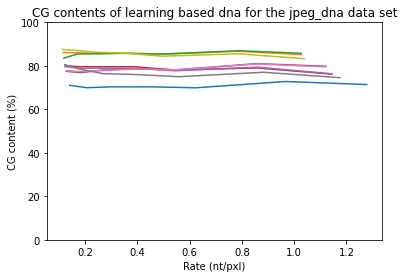

In [77]:
def cg_contents(model_name, data_set = 'jpeg_dna'): 
    """
    Plots of the percentage of CG nucleotides in dna strands in regards of the quality of the 
    encoding, computed for the 24 images of the kodak data set.  
    
    Parameters
    ----------
    model_name: string 
        name of the model to be used for dna encoding
        'anchor1', 'anchor3', 'benchmark codec' or 'learning based'
        
    Returns
    -------
    A plot saved in the folder plots/
    """
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10
    else : 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    
    
    for i in range(1, number_of_images): 
        cg = []
        bit_rate = []
            
        for q in range(1,8):
            if model_name == 'anchor1':
                dna = get_anchor_dna(1, i, q, data_set)
                img, x = get_anchor_tensor(1, i, q, data_set)
            elif model_name == 'anchor3':
                dna = get_anchor_dna(3, i, q, data_set)
                img, x = get_anchor_tensor(3, i, q, data_set)
            elif model_name == 'benchmark codec':
                dna = get_benchmark_dna(i, q, data_set)
                img, x = get_benchmark_tensor(i, q, data_set)
            elif model_name == 'learning based': 
                dna = get_learningbased_dna(i, q, data_set)
                img, x = get_learningbased_tensor(i, q, data_set)
            else: 
                print('Invalid model name : '  + model_name + '. The options are : anchor1, anchor3, benchmark codec or learning based.')
                return
            cg.append(CG_content(dna))
            bit_rate.append(compute_bit_rate(img, dna))
            
        plt.plot(bit_rate, cg)
        
    plt.xlabel('Rate (nt/pxl)')
    plt.ylabel('CG content (%)')
    plt.title('CG contents of ' + model_name +' dna for the ' + data_set + ' data set')
    plt.ylim(0, 100) 
    #plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.savefig('plots/cg_' + data_set + '_'+ model_name + '.jpeg', bbox_inches='tight')
    plt.show()
    


#cg_contents('anchor1')
#cg_contents('anchor3')
#cg_contents('benchmark codec')
#cg_contents('learning based')


### Homopolymers

In [78]:

def count_homopolymers(count, homopolymers, dna, i):
    if i == 0 :
        return count 
    elif dna[i] == dna[i-1] : 
        count_homopolymers(count, homo+1, dna, i-1)
    elif homo >= 3 : 
        count.append(homo)
        count_homopolymers(count, 0, dna, i-1)
    else : 
        count_homopolymers(count, 0, dna, i-1) 
        
def check_homopolymers(dna) :
    count = 0
    for i in range(len(dna)-2): 
        if ((dna[i] == dna[i+1]) & (dna[i+1] == dna[i+2])): 
            ++ count  
    if count > 0: 
        print (count_homopolymers(0, [], dna, len(dna)))
    return count 


In [79]:
def all_homopolymers(data_set = 'jpeg_dna'): 
    anchor1_count = 0
    anchor3_count = 0
    learningbased_count = 0
    benchmarkcodec_count = 0
    if data_set == 'kodak': 
        number_of_images = 24
    elif data_set == 'jpeg_dna': 
        number_of_images = 10
    else : 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    for q in range(1, 9): 
        for i in range(1, number_of_images + 1): 
            anchor1_dna = get_anchor_dna(1,i,q, data_set)
            anchor3_dna = get_anchor_dna(3,i,q, data_set)
            benchmarkcodec_dna = get_benchmark_dna(i,q, data_set)
            learningbased_dna = get_learningbased_dna(i,q, data_set)
            
            anchor1_count += check_homopolymers(anchor1_dna) 
            anchor3_count += check_homopolymers(anchor3_dna)
            learningbased_count += check_homopolymers(learningbased_dna)
            benchmarkcodec_count += check_homopolymers(benchmarkcodec_dna)

    print("Number of homopolymers in anchor 1 dna : " + str(anchor1_count))
    print("Number of homopolymers in anchor 3 dna : " + str(anchor3_count))
    print("Number of homopolymers in learning based dna : "+ str(learningbased_count))
    print("Number of homopolymers in benchmark codec dna : "+ str(learningbased_count))
    
    

In [80]:
#all_homopolymers()

### Metrics

In [133]:
def add_padding(a, b):
    # Pad the smaller tensor with zeros to match the size of the larger tensor
    height_diff = abs(b.shape[2] - a.shape[2])
    width_diff = abs(b.shape[3] - a.shape[3])

    padding = (width_diff // 2, width_diff - width_diff // 2,
               height_diff // 2, height_diff - height_diff // 2)
    # Find the smaller tensor
    if a.shape[2] < b.shape[2] or a.shape[3] < b.shape[3]:
        a = F.pad(a, padding)
    else:
        b = F.pad(b, padding)
    return a, b

#### PSNR


- PSNR = Peak Signal-to-Noise Ratio
- Measures the difference between an original image and a compressed or reconstructed version of it. 
- The higher the PSNR value, the better the quality of the compressed or reconstructed image.

\begin{equation}
PSNR = - 10 \cdot \log_{10} (MSE)
\end{equation}




In [134]:
def compute_psnr(a, b):
    if a.shape != b.shape:
        a, b = add_padding(a, b)
    mse = torch.mean((a - b)**2).item()
    return -10 * math.log10(mse)

#### MS-SSIM
- MS-SSIM = Multi-Scale Structural Similarity Index
- Measures the similarity between two images
- Takes into account multiple scales of image structures
- The higher the MS-SSIM, the higher the similqrity between 2 images

In [135]:
def compute_msssim(a, b):
    if a.shape != b.shape:
        a, b = add_padding(a,b)
    return ms_ssim(a, b, data_range=1.).item()

#### IW-SSIM
- IW-SSIM = Information-Weighted Structural Similarity Index
- Takes into account the importance of different regions in the image, and assigns them different weights based on their visual significance
- The higher the MS-SSIM, the higher the similqrity between 2 images

\begin{equation}
\text{IW-SSIM} = \frac{(2 \mu_a \mu_b + c_1)(2\sigma_{ab} + c_2)}{(\mu_a^2 + \mu_b^2 + c_1)(\sigma_a^2 + \sigma_b^2 + c_2)} \cdot \text{SSIM}
\end{equation}


In [137]:
def compute_iwssim(a, b, k=0.01):
    if a.shape != b.shape:
        a, b = add_padding(a, b)
    # Compute the constants c1 and c2 used in the IW-SSIM formula
    c1 = (k * 1) ** 2
    c2 = (k * 1) ** 2
    # Compute the mean, variance, and covariance of the two input images
    mean_a = a.mean(dim=(1, 2, 3), keepdim=True)
    mean_b = b.mean(dim=(1, 2, 3), keepdim=True)
    var_a = ((a - mean_a) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    var_b = ((b - mean_b) ** 2).mean(dim=(1, 2, 3), keepdim=True)
    cov_ab = ((a - mean_a) * (b - mean_b)).mean(dim=(1, 2, 3), keepdim=True)
    
    # Compute the SSIM value between the two input images using pytorch_msssim's ssim function
    ssim_val = ssim(a, b, data_range=1.0, win_size=11, size_average=True)
    
    # Compute the IW-SSIM value using the mean, variance, covariance, and SSIM values
    iwssim_val = ((2 * mean_a * mean_b + c1) * (2 * cov_ab + c2)) / ((mean_a ** 2 + mean_b ** 2 + c1) * (var_a + var_b + c2)) * ssim_val
    
    # Return the average IW-SSIM value across the batch
    return iwssim_val.mean().item()


In [84]:
def compute_bit_rate(img, dna): 
    h, w = img.size
    return len(dna)/(h*w)

### Plots

In [85]:
def compute_metric(metric_name, original_tensor, reconstructed_tensor): 
    
    """
    Computes the quality metric given by 'metric_name' for an encoded image, 
    in comparison to an original image. 

    Parameters
    ----------
    metric_name: string 
        name of the metric to be computed.
        'PSNR', 'PSNR-HVS-M' 'MS-SSIM', or 'IW-SSIM.
    original_tensor: tensor
        original image run through the different encoder
    reconstructed_tensor: tensor
        reconstructed image tensor
        

    Returns
    -------
    The computed value of the given quality metric for the specified image
    """
    if metric_name == 'PSNR-HVS-M':
        original_image = transforms.ToPILImage()(original_tensor.squeeze().cpu())
        reconstructed_image = transforms.ToPILImage()(reconstructed_tensor.squeeze().cpu())
        return compute_psnr_hvsm(original_image, reconstructed_image)
    elif metric_name == 'PSNR' : 
        return compute_psnr(original_tensor, reconstructed_tensor)
    elif metric_name == 'MS-SSIM': 
        return compute_msssim(original_tensor, reconstructed_tensor)
    elif metric_name =='IW-SSIM': 
        return compute_iwssim(original_tensor, reconstructed_tensor)
    else:
        print("Invalid argument : " + metric_name +". The available metrics are PSNR, MS-SSIM, IW-SSIM or PSNR-HVS-M")
        return

In [140]:
def plot_metric(metric_name, img_number, data_set = 'jpeg_dna'): 
    """
    Plots a quality metric given by metric_name, for a an image encoded by different models.
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    img_number: 
        number of the image of interest in the given data set

    Returns
    -------
    A plot saved in the folder /plots
    """
    if((data_set != 'jpeg_dna') & (data_set != 'kodak')): 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    
    if data_set == 'kodak' : 
        if(img_number < 1 or img_number > 24): 
            print('Ivalid image number, please enter a value between 1 and 24.')
            return
    if data_set == 'kodak' : 
        if(img_number < 1 or img_number > 10): 
            print('Ivalid image number, please enter a value between 1 and 10.')
            return
        
    if((metric_name != 'PSNR') & (metric_name != 'MS-SSIM') & (metric_name != 'IW-SSIM')): 
        print("Ivalid metric name, please enter  'PSNR', 'MS-SSIM', or 'IW-SSIM'.")
        return
    
    # Initialize empty lists to store metrics and bit rates for the image at all quality levels
    learning_based_metric = []
    anchor1_metric = [] 
    anchor3_metric = []
    benchmark_codec_metric = []
    learning_based_bitrates = []
    anchor1_bitrates = []
    anchor3_bitrates = []
    benchmark_codec_bitrates = []
    img, x = get_original_tensor(img_number, data_set)

   # Loop through quality levels 1-8
    for quality in range(1, 8):
        # Load image, tensor and dna for the learning-based method and calculate bit rate
        learning_based_img, learning_based_tensor = get_learningbased_tensor(img_number, quality, data_set)
        learning_based_dna = get_learningbased_dna(img_number, quality, data_set)
        learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))
        
        # Load image, tensor and dna for anchor1, calculate bit rate
        anchor1_img, anchor1_tensor = get_anchor_tensor(1, img_number, quality, data_set)
        anchor1_dna = get_anchor_dna(1, img_number, quality, data_set)
        anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

        # Load image, tensor and dna for anchor3, calculate bit rate
        anchor3_img, anchor3_tensor = get_anchor_tensor(3, img_number, quality, data_set)
        anchor3_dna = get_anchor_dna(3, img_number, quality, data_set)
        anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))

        
        # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
        benchmark_codec_img, benchmark_codec_tensor = get_benchmark_tensor(img_number, quality, data_set)
        benchmark_codec_dna = get_benchmark_dna(img_number, quality, data_set)
        benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))
        
        # Calculate metric for each model and add to corresponding list 
        
        learning_based_metric.append(compute_metric(metric_name, x, learning_based_tensor))
        anchor1_metric.append(compute_metric(metric_name, x, anchor1_tensor))
        anchor3_metric.append(compute_metric(metric_name, x, anchor3_tensor))
        benchmark_codec_metric.append(compute_metric(metric_name, x, benchmark_codec_tensor))
        
        
    # plot results
    if ((metric_name == 'PSNR') or (metric_name == 'PSNR-HVS-M')): 
        unit = ' (dB)'
    else : unit = ''
    plt.plot(learning_based_bitrates, learning_based_metric, label='Learning based', marker='o', markersize=3)
    #plt.plot(anchor1_bitrates, anchor1_metric, label='Anchor 1', marker='o', markersize=3)
    #plt.plot(anchor3_bitrates, anchor3_metric, label='Anchor 3', marker='o', markersize=3)
    #plt.plot(benchmark_codec_bitrates, benchmark_codec_metric, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
    plt.xlabel('Rate (nts/pxl)')
    plt.ylabel(metric_name + unit)
    plt.title(metric_name +' of the image ' + str(img_number)+ ' of the ' + data_set +  ' set for different models')
    plt.legend()
    plt.savefig('plots/'+ data_set + '_' + metric_name +'im' + str(img_number) +'.jpeg')
    plt.show()

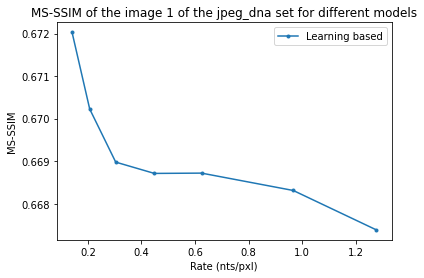

In [142]:
plot_metric('MS-SSIM',1)

In [59]:
def plot_all_metrics(img_number, data_set = 'jpeg_dna'): 
        plot_metric('IWSSIM', img_number, data_set)
        plot_metric('MSSSIM', img_number, data_set)
        plot_metric('PSNR', img_number, data_set)
        
def plot_all(data_set = 'jpeg_dna'): 
    for img_id in range(1,25):
        plot_all_metrics(img_id, data_set)

#plot_all()

In [123]:
def plot_avg_metric(metric_name, data_set = 'jpeg_dna'): 
    """
    Plots the average across all the images of the kodak data set of the quality metric 
    given by metric_name. The images are encoded by different models. 
    
    Parameters
    ----------
    metric_name: string 
        name of the metric to be plotted
        'PSNR', 'MSSSIM', or 'IWSSIM'
    data_set : string
        name of the data set on which to perform the computations
        'jpeg_dna' or 'kodak'
    Returns
    -------
    A plot saved in the folder /plots
    """
    
    # Check input
    if((metric_name != 'PSNR') & (metric_name != 'MS-SSIM') & (metric_name != 'IW-SSIM')): 
        print("Ivalid metric name, please enter  'PSNR', 'MS-SSIM', or 'IW-SSIM'.")
        return
    if data_set == 'kodak': 
        number_of_images = 25
    elif data_set == 'jpeg_dna': 
        number_of_images = 11
    else : 
        print("Ivalid data set name, please enter  'jpeg_dna' or 'kodak'.")
        return
    
    # Initialize empty lists to store average metrics and bit rates for each anchor type
    learning_based_avg_metrics = []
    anchor1_avg_metrics = []
    anchor3_avg_metrics = []
    benchmark_codec_avg_metrics = []
    
    learning_based_avg_bitrates = []
    anchor1_avg_bitrates = []
    anchor3_avg_bitrates = []
    benchmark_codec_avg_bitrates = []
    
    # Loop through quality levels 1-8
    for quality in range(1, 9):
        # Initialize empty lists to store metrics and bit rates for all images at the current quality level
        learning_based_metric = []
        anchor1_metric = [] 
        anchor3_metric = []
        benchmark_codec_metric = []
        
        learning_based_bitrates = []
        anchor1_bitrates = []
        anchor3_bitrates = []
        benchmark_codec_bitrates = []
        # Loop through images 1-24 (kodak data set)
        for img_id in range(1, number_of_images):
            img, x = get_original_tensor(img_id, data_set)
            
            # Load image, tensor and dna for the learning-based method and calculate bit rate
            learning_based_img, learning_based_tensor = get_learningbased_tensor(img_id, quality, data_set)
            learning_based_dna = get_learningbased_dna(img_id, quality, data_set)
            learning_based_bitrates.append(compute_bit_rate(learning_based_img, learning_based_dna))
            
            # Load image, tensor and dna for anchor1, calculate bit rate
            anchor1_img, anchor1_tensor = get_anchor_tensor(1, img_id, quality, data_set)
            anchor1_dna = get_anchor_dna(1, img_id, quality, data_set)
            anchor1_bitrates.append(compute_bit_rate(anchor1_img, anchor1_dna))

            # Load image, tensor and dna for anchor3, calculate bit rate
            anchor3_img, anchor3_tensor = get_anchor_tensor(3, img_id, quality, data_set)
            anchor3_dna = get_anchor_dna(3, img_id, quality, data_set)
            anchor3_bitrates.append(compute_bit_rate(anchor3_img, anchor3_dna))
            
            # Load image, tensor and dna for the JPEG DNA benchmark codec, calculate bit rate
            benchmark_codec_img, benchmark_codec_tensor = get_benchmark_tensor(img_id, quality, data_set)
            benchmark_codec_dna = get_benchmark_dna(img_id, quality, data_set)
            benchmark_codec_bitrates.append(compute_bit_rate(benchmark_codec_img, benchmark_codec_dna))
        
            # Calculate metric for each model and add to corresponding list
            learning_based_metric.append(compute_metric(metric_name, x, learning_based_tensor))
            anchor1_metric.append(compute_metric(metric_name, x, anchor1_tensor))
            anchor3_metric.append(compute_metric(metric_name, x, anchor3_tensor))
            benchmark_codec_metric.append(compute_metric(metric_name, x, benchmark_codec_tensor))
        
        # Calculate the average bit rate and metric, and add them to the corresponding lists 
        learning_based_avg_bitrates.append(mean(learning_based_bitrates))
        learning_based_avg_metrics.append(mean(learning_based_metric))
        anchor1_avg_bitrates.append(mean(anchor1_bitrates))
        anchor1_avg_metrics.append(mean(anchor1_metric))
        anchor3_avg_bitrates.append(mean(anchor3_bitrates))
        anchor3_avg_metrics.append(mean(anchor3_metric))
        benchmark_codec_avg_bitrates.append(mean(benchmark_codec_bitrates))
        benchmark_codec_avg_metrics.append(mean(benchmark_codec_metric))
    
    # Plot the result
    unit = ''
    if(metric_name == 'PSNR'): 
        unit = (' (dB)')
    plt.plot(learning_based_avg_bitrates, learning_based_avg_metrics, label='Learning based', marker='o', markersize=3)
    plt.plot(anchor1_avg_bitrates, anchor1_avg_metrics, label='Anchor 1', marker='o', markersize=3)
    plt.plot(anchor3_avg_bitrates, anchor3_avg_metrics, label='Anchor 3', marker='o', markersize=3)
    plt.plot(benchmark_codec_avg_bitrates, benchmark_codec_avg_metrics, label='JPEG DNA Benchmark Codec', marker='o', markersize=3)
    plt.xlabel('Rate (nts/pxl)')
    plt.ylabel(metric_name + unit)
    plt.title('Average ' + metric_name +' across the ' + data_set + ' set for different models')
    plt.legend()
    plt.savefig('plots/avg_'+ data_set + '_' + metric_name +'.jpeg')
    plt.show()

In [122]:
plot_avg_metric('IW-SSIM', 'kodak')

Ivalid metric name, please enter  'PSNR', 'MSSSIM', or 'IWSSIM'.


In [125]:
def plot_all_average_metrics(data_set='jpeg_dna'):
    """
    Plots the average PSNR, MSSSIM, and IW-SSIM across all the images of the kodak data set 
    at different quality levels.
    The images are encoded by different models. 
    """
    plot_avg_metric('PSNR', data_set)
    plot_avg_metric('MS-SSIM', data_set)
    plot_avg_metric('IW-SSIM', data_set)

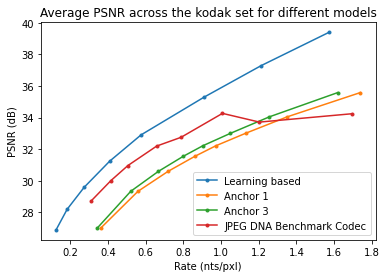

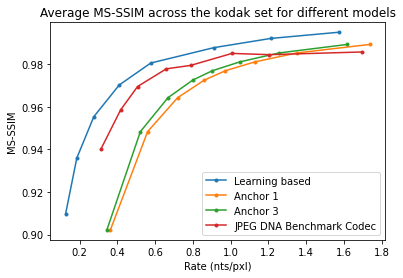

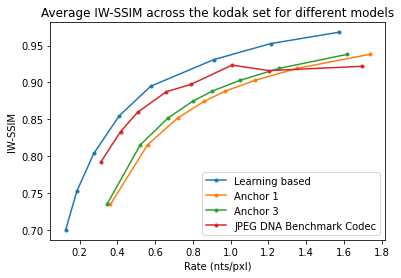

In [126]:
plot_all_average_metrics('kodak')

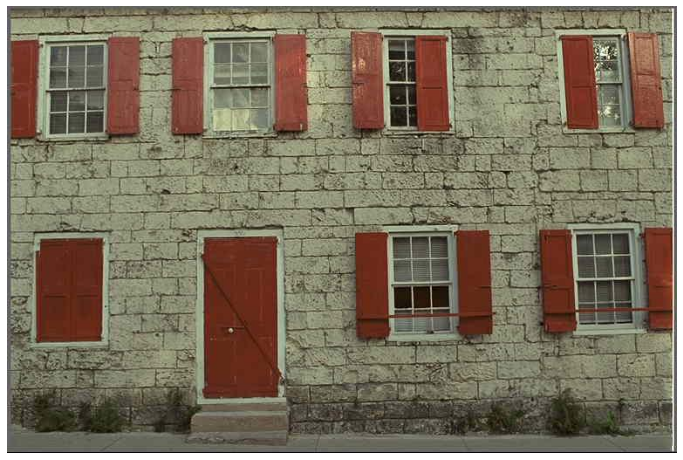

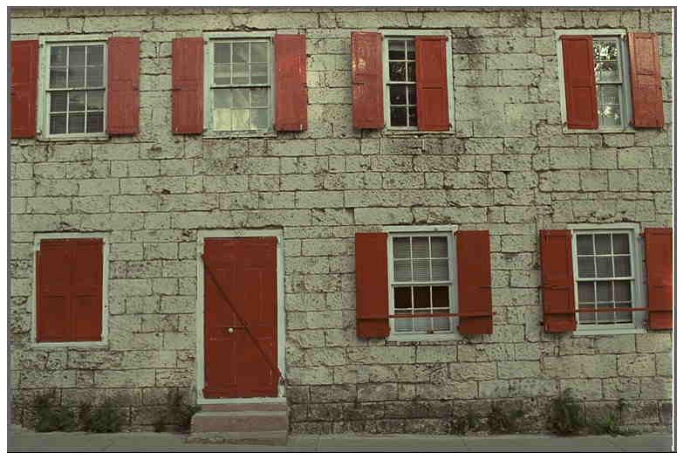

In [119]:
    img6, x6 = get_benchmark_tensor(1, 6, 'kodak')
    img7, x7 = get_benchmark_tensor(1, 7, 'kodak')
    plt.figure(figsize=(12, 9))
    plt.axis('off')
    plt.imshow(img6)
    plt.show()
    plt.figure(figsize=(12, 9))
    plt.axis('off')
    plt.imshow(img7)
    plt.show()